In [40]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv('../data/survey_results_public.csv')

# Processing

In [42]:
df.head(3)

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0


In [43]:
df = df[['Age', 'RemoteWork', 'EdLevel', 'YearsCodePro', 'Country', 'Industry', 'Employment', 'ConvertedCompYearly']]

df = df.rename({'ConvertedCompYearly': 'Salary'}, axis=1)

df = df[df["Salary"].notnull()]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48019 entries, 1 to 89171
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           48019 non-null  object 
 1   RemoteWork    47940 non-null  object 
 2   EdLevel       48019 non-null  object 
 3   YearsCodePro  47825 non-null  object 
 4   Country       48019 non-null  object 
 5   Industry      27747 non-null  object 
 6   Employment    48007 non-null  object 
 7   Salary        48019 non-null  float64
dtypes: float64(1), object(7)
memory usage: 3.3+ MB


In [45]:
df = df.dropna()

df.sample(5)

,Age,RemoteWork,EdLevel,YearsCodePro,Country,Industry,Employment,Salary
15885,35-44 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",17,Israel,Advertising Services,"Employed, full-time",257123.0
71662,35-44 years old,In-person,Some college/university study without earning ...,4,United States of America,Retail and Consumer Services,"Employed, full-time",65000.0
14278,Under 18 years old,Remote,Some college/university study without earning ...,2,Russian Federation,"Information Services, IT, Software Development...","Employed, full-time",24000.0
78819,25-34 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,India,"Information Services, IT, Software Development...","Employed, full-time",16358.0
18482,45-54 years old,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,Belgium,"Information Services, IT, Software Development...","Independent contractor, freelancer, or self-em...",128507.0


In [46]:
df = df[df['Employment'] == 'Employed, full-time']

df = df.drop('Employment', axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23510 entries, 1 to 89171
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           23510 non-null  object 
 1   RemoteWork    23510 non-null  object 
 2   EdLevel       23510 non-null  object 
 3   YearsCodePro  23510 non-null  object 
 4   Country       23510 non-null  object 
 5   Industry      23510 non-null  object 
 6   Salary        23510 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.4+ MB


In [47]:
df.shape

(23510, 7)

In [48]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

country_map = shorten_categories(df.Country.value_counts(), 200)
df['Country'] = df['Country'].map(country_map)
#df.Country.value_counts()

In [49]:
df['Country'] = df['Country'].replace({
    'United States of America': 'United States',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Russian Federation': 'Russian'
})

In [50]:
df.Country.value_counts()

Country
United States     6175
Other             4896
Germany           1934
United Kingdom    1768
India             1194
Canada            1057
France             798
Brazil             624
Netherlands        571
Spain              557
Australia          551
Italy              518
Poland             467
Sweden             466
Switzerland        306
Israel             269
Portugal           247
Denmark            243
Austria            234
Finland            216
Norway             216
Russian            203
Name: count, dtype: int64

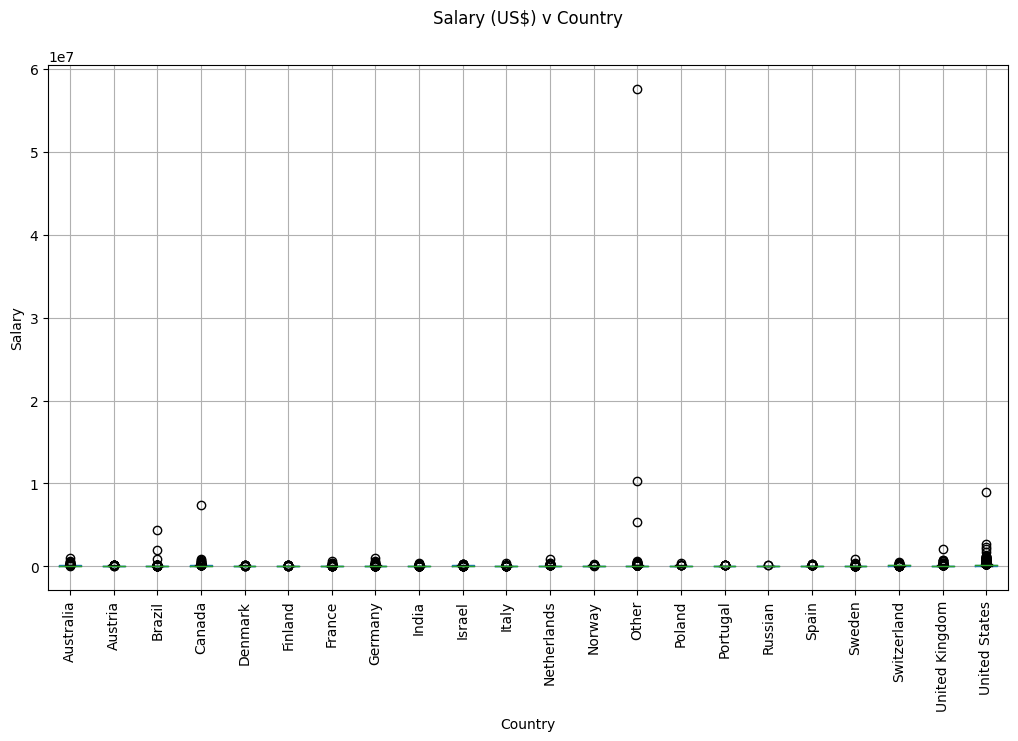

In [51]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [52]:
df = df[df['Salary'] <= 250000]
df = df[df['Salary'] >= 10000]
df = df[df['Country'] != 'Other']

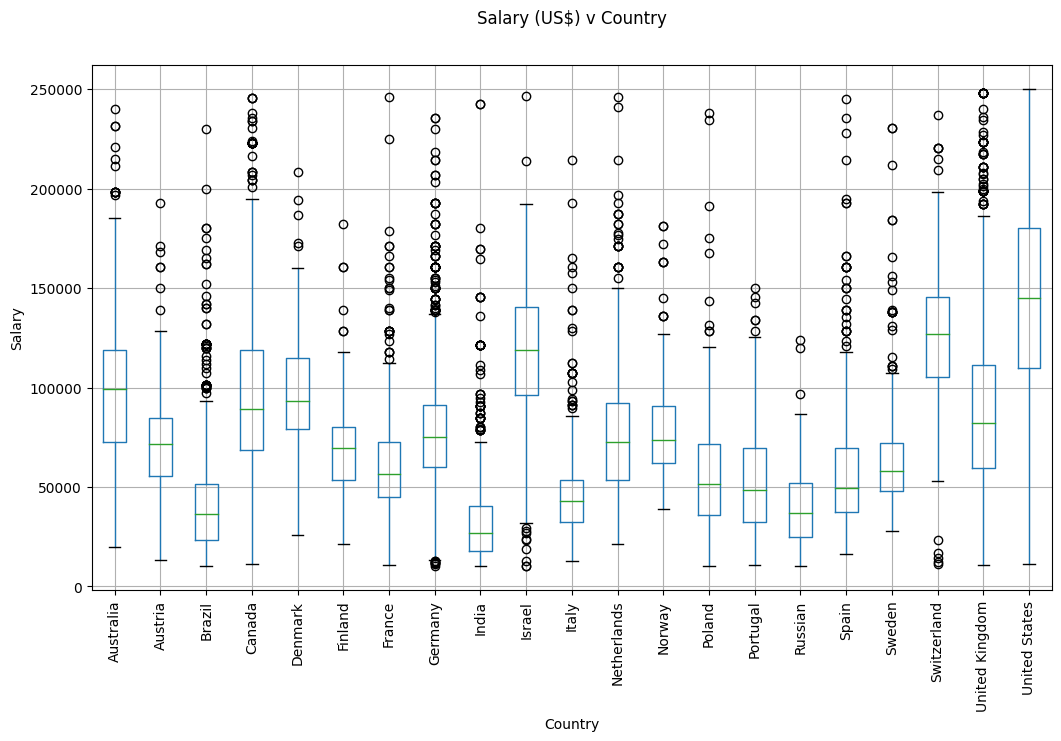

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax = ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

In [54]:
#df.YearsCodePro.value_counts()

In [55]:
def clear_experience(x):
    if x == 'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df['YearsCodePro'] = df['YearsCodePro'].apply(clear_experience)

In [56]:
df['EdLevel'].unique().tolist()

['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
 'Some college/university study without earning a degree',
 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
 'Associate degree (A.A., A.S., etc.)',
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
 'Primary/elementary school',
 'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
 'Something else']

In [57]:
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)

In [58]:
df['EdLevel'].unique().tolist()

['Bachelor’s degree', 'Less than a Bachelors', 'Master’s degree', 'Post grad']

In [59]:
df

,Age,RemoteWork,EdLevel,YearsCodePro,Country,Industry,Salary
2,45-54 years old,"Hybrid (some remote, some in-person)",Bachelor’s degree,23.0,United States,"Information Services, IT, Software Development...",250000.0
5,35-44 years old,Remote,Less than a Bachelors,21.0,United Kingdom,Other,96828.0
6,35-44 years old,Remote,Less than a Bachelors,3.0,United States,"Information Services, IT, Software Development...",135000.0
7,25-34 years old,Remote,Bachelor’s degree,3.0,United States,Financial Services,80000.0
12,25-34 years old,Remote,Bachelor’s degree,9.0,United States,Other,75000.0
...,...,...,...,...,...,...,...
89154,35-44 years old,"Hybrid (some remote, some in-person)",Bachelor’s degree,8.0,United States,"Information Services, IT, Software Development...",75000.0
89156,25-34 years old,Remote,Bachelor’s degree,8.0,United States,"Information Services, IT, Software Development...",195000.0
89162,35-44 years old,Remote,Master’s degree,24.0,Brazil,"Information Services, IT, Software Development...",50719.0
89167,18-24 years old,Remote,Bachelor’s degree,2.0,India,Retail and Consumer Services,15752.0


In [60]:
df.RemoteWork.value_counts()

RemoteWork
Hybrid (some remote, some in-person)    7887
Remote                                  7188
In-person                               2153
Name: count, dtype: int64

In [61]:
df['RemoteWork'] = df.RemoteWork.replace('Hybrid (some remote, some in-person)', 'Hybrid')

In [62]:
df.Industry.value_counts()

Industry
Information Services, IT, Software Development, or other Technology    7765
Financial Services                                                     2067
Other                                                                  2060
Manufacturing, Transportation, or Supply Chain                         1371
Healthcare                                                             1194
Retail and Consumer Services                                           1042
Higher Education                                                        606
Insurance                                                               410
Advertising Services                                                    383
Oil & Gas                                                               139
Legal Services                                                          114
Wholesale                                                                77
Name: count, dtype: int64

In [63]:
df['Industry'] = df.Industry.replace('Information Services, IT, Software Development, or other Technology', 'IT, Software Development, Technology')
df['Industry'] = df.Industry.replace('Manufacturing, Transportation, or Supply Chain', 'Manufacturing, Transportation, Supply')

In [64]:
df.Age.value_counts()

Age
25-34 years old       8184
35-44 years old       5094
45-54 years old       1664
18-24 years old       1626
55-64 years old        573
65 years or older       73
Prefer not to say        9
Under 18 years old       5
Name: count, dtype: int64

In [65]:
df = df[df.Age != 'Prefer not to say']
df = df[df.Age != 'Under 18 years old']

In [66]:
df

,Age,RemoteWork,EdLevel,YearsCodePro,Country,Industry,Salary
2,45-54 years old,Hybrid,Bachelor’s degree,23.0,United States,"IT, Software Development, Technology",250000.0
5,35-44 years old,Remote,Less than a Bachelors,21.0,United Kingdom,Other,96828.0
6,35-44 years old,Remote,Less than a Bachelors,3.0,United States,"IT, Software Development, Technology",135000.0
7,25-34 years old,Remote,Bachelor’s degree,3.0,United States,Financial Services,80000.0
12,25-34 years old,Remote,Bachelor’s degree,9.0,United States,Other,75000.0
...,...,...,...,...,...,...,...
89154,35-44 years old,Hybrid,Bachelor’s degree,8.0,United States,"IT, Software Development, Technology",75000.0
89156,25-34 years old,Remote,Bachelor’s degree,8.0,United States,"IT, Software Development, Technology",195000.0
89162,35-44 years old,Remote,Master’s degree,24.0,Brazil,"IT, Software Development, Technology",50719.0
89167,18-24 years old,Remote,Bachelor’s degree,2.0,India,Retail and Consumer Services,15752.0


In [67]:
le_age = LabelEncoder()
df['Age'] = le_age.fit_transform(df['Age'])
df.Age.unique()

array([3, 2, 1, 4, 0, 5])

In [68]:
le_work = LabelEncoder()
df['RemoteWork'] = le_work.fit_transform(df['RemoteWork'])
df.RemoteWork.unique()

array([0, 2, 1])

In [69]:
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df.EdLevel.unique()

array([0, 1, 2, 3])

In [70]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df.Country.unique()

array([20, 19, 11,  7,  6, 16, 10,  3, 18,  2, 12,  8,  5, 14,  1, 17,  4,
       15,  9, 13,  0])

In [71]:
le_industry = LabelEncoder()
df['Industry'] = le_industry.fit_transform(df['Industry'])
df.Industry.unique()

array([ 4,  9,  1,  7, 10,  3,  5,  2,  8, 11,  6,  0])

# Model

In [72]:
X, y = df.drop('Salary', axis=1), df['Salary']

In [73]:
X

,Age,RemoteWork,EdLevel,YearsCodePro,Country,Industry
2,3,0,0,23.0,20,4
5,2,2,1,21.0,19,9
6,2,2,1,3.0,20,4
7,1,2,0,3.0,20,1
12,1,2,0,9.0,20,9
...,...,...,...,...,...,...
89154,2,0,0,8.0,20,4
89156,1,2,0,8.0,20,4
89162,2,2,2,24.0,2,4
89167,0,2,0,2.0,8,10


In [74]:
linear_reg = LinearRegression()
linear_reg.fit(X, y.values)

y_pred = linear_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$45,768.87


In [75]:
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X, y.values)

y_pred = dec_tree_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$20,899.57


In [76]:
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X, y.values)

y_pred = random_forest_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$22,785.09


In [77]:
X.columns.tolist()

['Age', 'RemoteWork', 'EdLevel', 'YearsCodePro', 'Country', 'Industry']

In [78]:
X = np.array([["18-24 years old",  "Remote",'Master’s degree', 2, "Germany", "Healthcare"]])
X

array([['18-24 years old', 'Remote', 'Master’s degree', '2', 'Germany',
        'Healthcare']], dtype='<U21')

In [79]:
X[:, 0] = le_age.transform(X[:,0])
X[:, 1] = le_work.transform(X[:,1])
X[:, 2] = le_education.transform(X[:,2])
X[:, 4] = le_country.transform(X[:,4])
X[:, 5] = le_industry.transform(X[:,5])
X = X.astype(float)
X

array([[0., 2., 2., 2., 7., 2.]])

In [80]:
y_pred = dec_tree_reg.predict(X)
y_pred

array([77104.])

In [81]:
data = {"model": dec_tree_reg, "le_age": le_age, "le_work":le_work, "le_education": le_education, "le_country": le_country, "le_industry": le_industry}
with open('model_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [82]:
with open('model_steps.pkl', 'rb') as file:
    data = pickle.load(file)
    
regressor_loaded = data['model']
le_age = data['le_age']
le_work = data['le_work']
le_education = data['le_education']
le_country = data['le_country']
le_industry = data['le_industry']

In [83]:
y_pred = regressor_loaded.predict(X)
y_pred

array([77104.])